<a href="https://colab.research.google.com/github/desunny/steel-ml/blob/dev/%EC%83%9D%EC%82%B0_%EC%86%8C%EC%9A%94%EC%8B%9C%EA%B0%84_%EC%98%88%EC%B8%A1(on)_%EC%8B%A4%EC%8A%B5%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
* 최초 작성일 : 2022.06.09
* 최종 수정일 : 2022.06.16
---




# **1. 개요 및 데이터 불러오기** <br>

### 1-1. 개요



> **분석목표**
>* 황삭기 작업 소요시간에 영향을 미치는 요소를 파악할 수 있다.
>* 과거 실적 데이터를 이용하여 만든 예측모델을 통해 모든 재공들의 작업 소요시간을 미리 파악하고, 이를 통해 황삭기의 시간기반 부하상황을 확인할 수 있다.
>
> **실습내용**
>1. 황삭기 작업실적 데이터에 대한 이해  
>2. 탐색적 데이터 분석(EDA), 시각화를 통한 데이터 특성 파악
>3. 이상 데이터 처리 및 파생변수 생성
>4. 데이터 분리(train, test) 
>5. 예측모델(Regression) 학습 및 평가
>6. 하이퍼파라미터 튜닝
>
> **실습 데이터**
>
>1. 황삭기는 Bite, Drill 등의 공구로 표면을 깎아내어 소재의 조직 및 물리적인 성질의 변화없이 형상만 변화 시키는 가공 설비이다.
>
>2. 실습데이터는 황삭설비 1개의 약 3년치 MES 작업실적 데이터로 크게 ①소재별 특성 데이터와 ②가공 후 작업 결과 데이터로 구성되어 있다.
>
>3. ① 소재별 특성 데이터 는 대표적으로 소재의 사이즈(외경, 길이 등)와 투입량(중량, 수량), 가공 후 목표 외경, 강종, 작업표준(이동속도/절입량) 이 있다. <BR> ② 가공 후 작업 결과 데이터는 대표적으로 작업 시작/종료 시간, 작업후 생산 사이즈(외경, 길이 등), 생산량(중량, 수량) 이 있다.<BR> _(참고) ②의 경우 작업 전 소재에서는 알 수 없는 정보이기 때문에 추후 예측모델 생성시 제외해야 한다.(3-2 row filtering 참조)_
>
> **데이터 구성**
>
>* 데이터는 csv파일로 약 27,100개의 데이터로 구성 되어 있다.
>* **굵은 글씨**는 분석에 사용한 컬럼이다. 실제 생성되는 데이터는 보다 복잡하지만 단순화 하였다. 
>* 황삭기 이해를 돕기위한 영상 : [링크](https://www.youtube.com/watch?v=BFoX-CAn1Co)
>
>
>| 컬럼명           | 설명                             |
>|------------------|----------------------------------|
>| FACTORY          | 공장코드                         |
>| WORK_SHAPE       | 작업조(1근/2근/3근)              |
>| **INPUT_ED**         | 투입되는 소재의 외경(mm)         |
>| **INPUT_LENGTH**     | 투입되는 소재의 개별 길이(mm)    |
>| **INPUT_QTY**        | 투입 총 수량(개)                 |
>| **DIRECTION_ED**   | 가공 후 목표 외경(mm)            |
>| **OUTPUT_ED**        | 생산된 소재의 외경(mm)           |
>| **STEEL_CATEGORY**   | 투입 강종 분류                   |
>| **WORK_START_DT**    | 작업시작일시                     |
>| **WORK_END_DT**      |  작업종료일시                    |


In [ ]:
#data clone
!git clone https://github.com/desunny/steel-ml/

Cloning into 'steel-ml'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [ ]:
#자주 사용하는 라이브러리 임포트 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#소숫점 자리수 표시 방법 지정 
pd.options.display.float_format = '{:.5f}'.format


#경고메세지 제거 
import warnings
warnings.filterwarnings('ignore')

### 1-2. 데이터 불러오기

In [ ]:
#생산소요시간로그 데이터 읽어오기 
location = "./steel-ml/datasets/steel_ai_01_on.csv"
df_tmp = pd.read_csv(location, header=0)
df_tmp.head()


,FACTORY,WORK_SHAPE,INPUT_ED,INPUT_LENGTH,INPUT_QTY,DIRECTION_ED,OUTPUT_ED,STEEL_CATEGORY,WORK_START_DT,WORK_END_DT
0,F1,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 7:00,2017-01-02 7:40
1,F1,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 7:40,2017-01-02 8:20
2,F1,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 8:20,2017-01-02 9:00
3,F1,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 9:00,2017-01-02 9:40
4,F1,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 9:40,2017-01-02 10:20


### 1-3. 데이터 확인

* null 확인
  * NULL 값이 없음을 확인
* 데이터 타입 확인
    * STEEL_CATEGORY와 WORK_SHAPE의 경우 내용은 정수이지만 가지고 있는 의미는 문자이기 때문에 *int형*을 각각 *category 형* 과 *object 형*으로 변환 진행
    * STEEL_GRADE : 4자리 숫자로 구성된 강종 분류 데이터
    * WORK_SHAPE : 작업 형태 분류로 1, 2, 3 값은 각각 1근(주간), 2근(중간), 3근(야간)을 의미함

| 데이터 타입     | 설명                 |
|:---------------:|----------------------|
| object          | 문자열 or 복합형     |
| int64           | 정수형               |
| float64         | 실수형               |
| bool            | boolean(참/거짓)     |
| category        | 카테고리형           |
| <left>데이터 타입 관련 참고 : [링크](https://wikidocs.net/78180)  |

 

In [ ]:
#Null 정보와 데이터 타입정보 확인


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27150 entries, 0 to 27149
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FACTORY         27150 non-null  object 
 1   WORK_SHAPE      27150 non-null  int64  
 2   INPUT_ED        27150 non-null  float64
 3   INPUT_LENGTH    27150 non-null  int64  
 4   INPUT_QTY       27150 non-null  int64  
 5   DIRECTION_ED    27150 non-null  float64
 6   OUTPUT_ED       27150 non-null  float64
 7   STEEL_CATEGORY  27150 non-null  int64  
 8   WORK_START_DT   27150 non-null  object 
 9   WORK_END_DT     27150 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 2.1+ MB


* 데이터 타입 변경

In [ ]:
#STEEL_CATEGORY와 WORK_SHAPE의 경우 내용은 정수이지만 가지고 있는 의미는 문자이기 때문에 
#int형을 각각 category 형 과 object 형으로 변환 진행


FACTORY             object
WORK_SHAPE          object
INPUT_ED           float64
INPUT_LENGTH         int64
INPUT_QTY            int64
DIRECTION_ED       float64
OUTPUT_ED          float64
STEEL_CATEGORY    category
WORK_START_DT       object
WORK_END_DT         object
dtype: object

* 수치형 데이터 요약 확인

,INPUT_ED,INPUT_LENGTH,INPUT_QTY,DIRECTION_ED,OUTPUT_ED
count,27150.00000,27150.00000,27150.00000,27150.00000,27150.00000
mean,162.51097,6663.80840,3.09912,156.12218,156.62533
std,14.27039,961.17961,1.93788,13.54787,18.64325
min,124.00000,3200.00000,1.00000,114.00000,1.00000
25%,154.00000,5800.00000,3.00000,148.00000,148.50000
50%,154.00000,6700.00000,3.00000,148.00000,148.60000
75%,175.00000,7600.00000,3.00000,168.00000,168.50000
max,214.00000,9500.00000,300.00000,210.00000,2017.00000


# **2. 데이터 탐색** <br>

---
데이터 탐색 파트는 아래 순서로 진행됨<br>
2-1.   중복데이터 처리<br>
2-2.   종속변수 생성<br>
2-3.   개별 분포 확인<br>
2-4.   소요시간에 따른 분포 확인<br>
2-5.   상관관계 확인<br>

---


### 2-1. 중복데이터 처리

In [ ]:
# 전체 데이터 수


(27150, 10)

In [ ]:
 # 중복 데이터 수


(9, 10)

In [ ]:
# 중복 제거 후 데이터 수


(27141, 10)

### 2-2. 종속변수 생성


  * 작업소요시간(분) = 작업종료시간 - 작업시작시간
  * diff = work_end_dt - work_start_dt

In [ ]:
#종속 변수 생성 


,diff,WORK_START_DT,WORK_END_DT
0,40,2017-01-02 7:00,2017-01-02 7:40
1,40,2017-01-02 7:40,2017-01-02 8:20
2,40,2017-01-02 8:20,2017-01-02 9:00
3,40,2017-01-02 9:00,2017-01-02 9:40
4,40,2017-01-02 9:40,2017-01-02 10:20


### 2-3. 개별 분포 확인

*  수치형 변수 분포 확인(histogram)

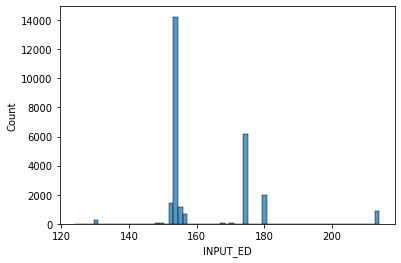

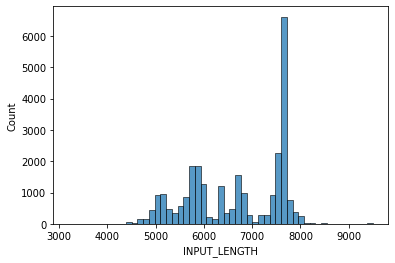

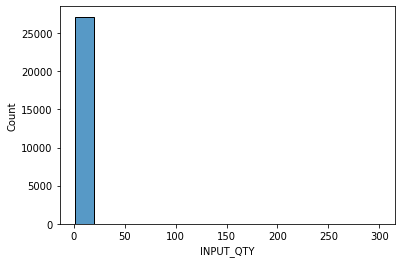

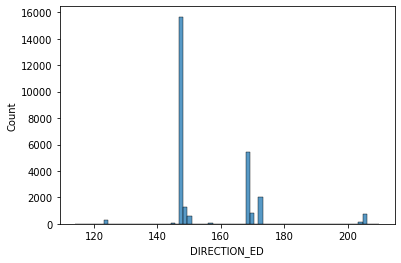

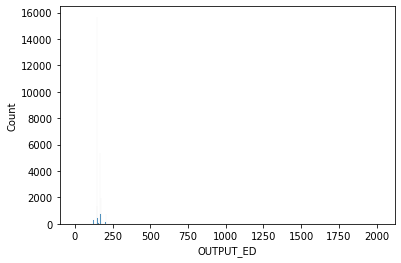

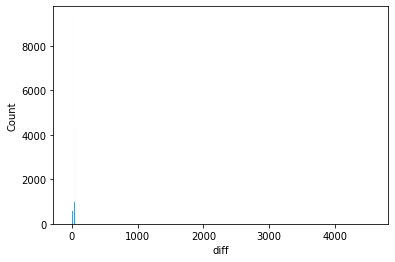

In [ ]:
# 모든 수치형 변수에 대해 히스토그램 확인


* countplot 함수를 이용하여 개별 분포 자세히 확인
  * countplot 함수의 경우 개별 모든 값을 기준으로 count를 하여 bar-plot을 그리기 때문에 너무 많은 수준을 갖는 컬럼(이 경우에는 diff)에 대해서는 그리지 않는 것을 권장


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


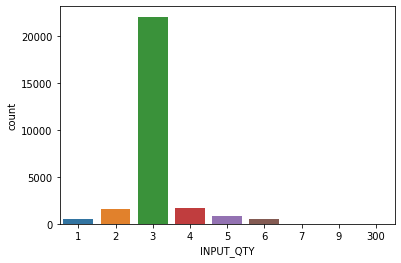

In [ ]:
#전체 투입수량 분포


* 값 필터링을 통해 개별 분포 자세히 확인
  * 소요시간(diff) : 0분초과 120분 이하 필터링

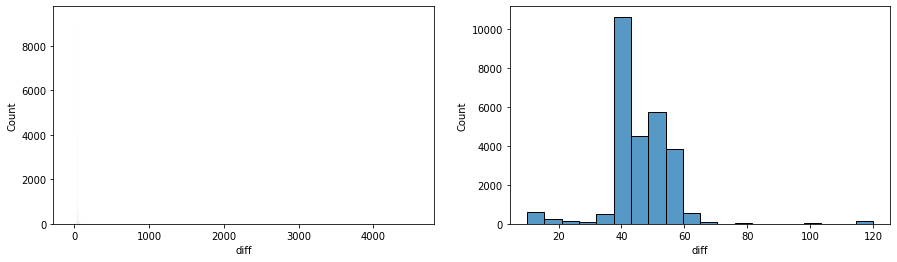

In [ ]:
#종속변수 - diff 기준 분포 확인 


*  범주형 변수 분포 확인
  * FACTORY의 경우 모두 1개의 값('F1')을 가짐



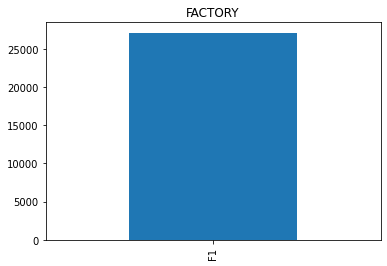

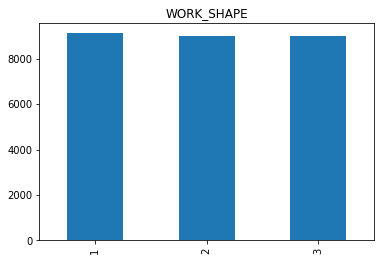

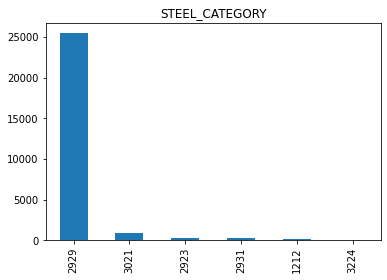

In [ ]:
# 모든 범주형 변수에 대해 히스토그램 확인




### 2-4. 소요시간에 따른 분포 확인

* 수치형 변수와 소요시간 간 분포 확인(scatter-plot)

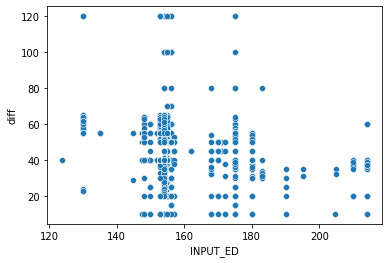

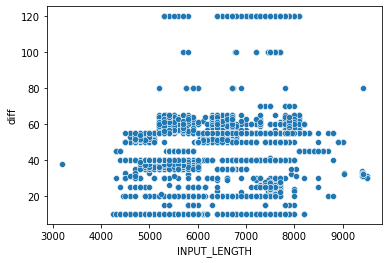

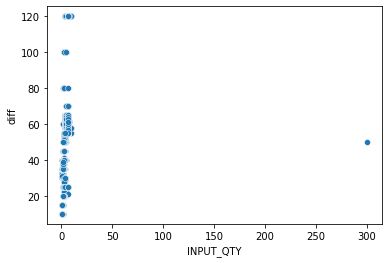

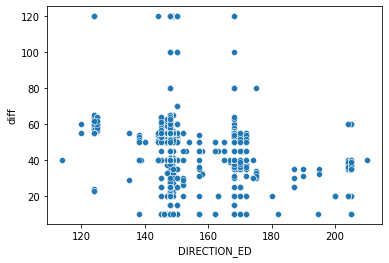

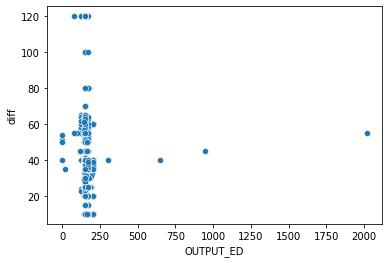

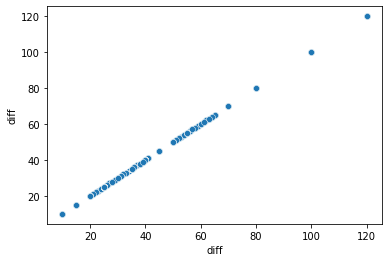

In [ ]:
# 모든 수치형 변수에 대해 산점도 확인


* 범주형 변수의 소요시간 분포 확인(box-plot)
  * 그룹 별로 소요시간 분포가 차이가 나는지 상자그림으로 확인
  * 소요시간 0분 ~ 120분 데이터를 기준으로 확인

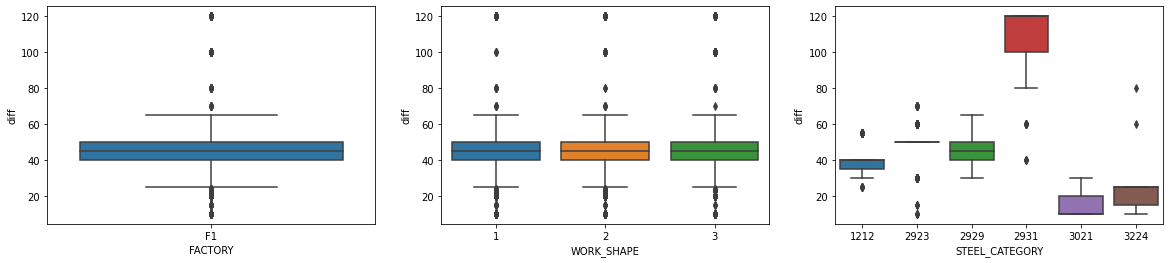

In [ ]:
#범주형 변수의 소요시간 분포 확인 (box-plot)
# 3개의 plot 그리기, # 가로폭 설정


* 수치형 변수와 소요시간 간 산점도에 범주형 변수 추가하여 확인 (scatter-plot)
  * 범주형 변수 중 diff 분포에 차이를 보였던 강종분류(STEEL_CATEGORY)를 색상으로 하여 산점도 확인

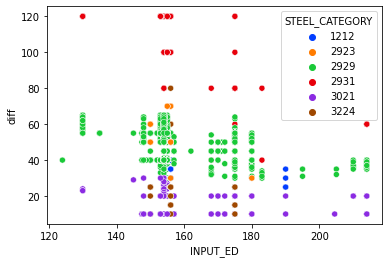

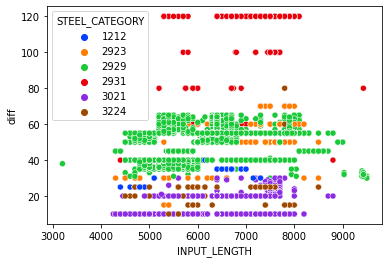

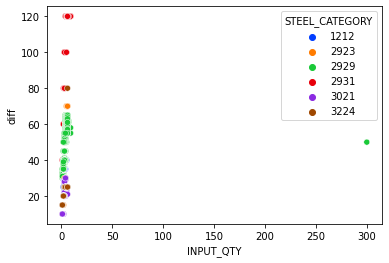

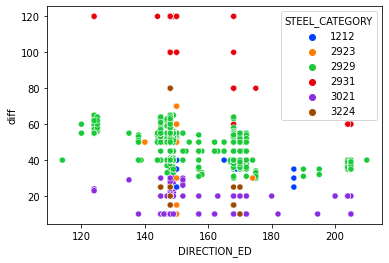

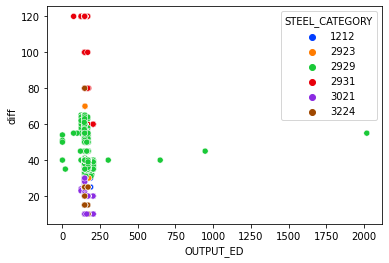

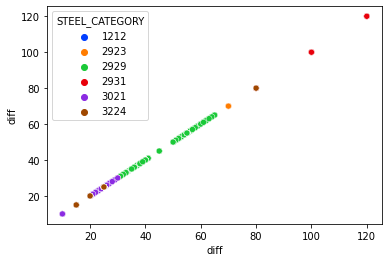

In [ ]:
#수치형 변수와 소요시간 간 산점도에 범주형 변수 추가하여 확인


### 2-5. 상관관계 확인

* **상관계수** : 두 변수 사이의 직선 관계를 나타내는 지표
* -1~1 사이 값을 가지며 절대값이 1에 가까울수록 강한 선형 관계를 의미
  * 투입/생산/목표 **외경** 간 상관관계 높음
  * 투입/생산 **길이** 간 상관관계 높음
  * 투입/생산 **중량** 간 상관관계 높음
<figure>
<left>
<img src='https://www.datadeck.com/en/blog/wp-content/uploads/2018/11/cor-examples.png' />
</left>
</figure>


,INPUT_ED,INPUT_LENGTH,INPUT_QTY,DIRECTION_ED,OUTPUT_ED,diff
INPUT_ED,1.00000,-0.62267,-0.13687,0.99855,0.71561,-0.08587
INPUT_LENGTH,-0.62267,1.00000,-0.02741,-0.62209,-0.45215,0.04079
INPUT_QTY,-0.13687,-0.02741,1.00000,-0.13510,-0.09600,0.08367
DIRECTION_ED,0.99855,-0.62209,-0.13510,1.00000,0.71670,-0.08464
OUTPUT_ED,0.71561,-0.45215,-0.09600,0.71670,1.00000,-0.06076
diff,-0.08587,0.04079,0.08367,-0.08464,-0.06076,1.00000


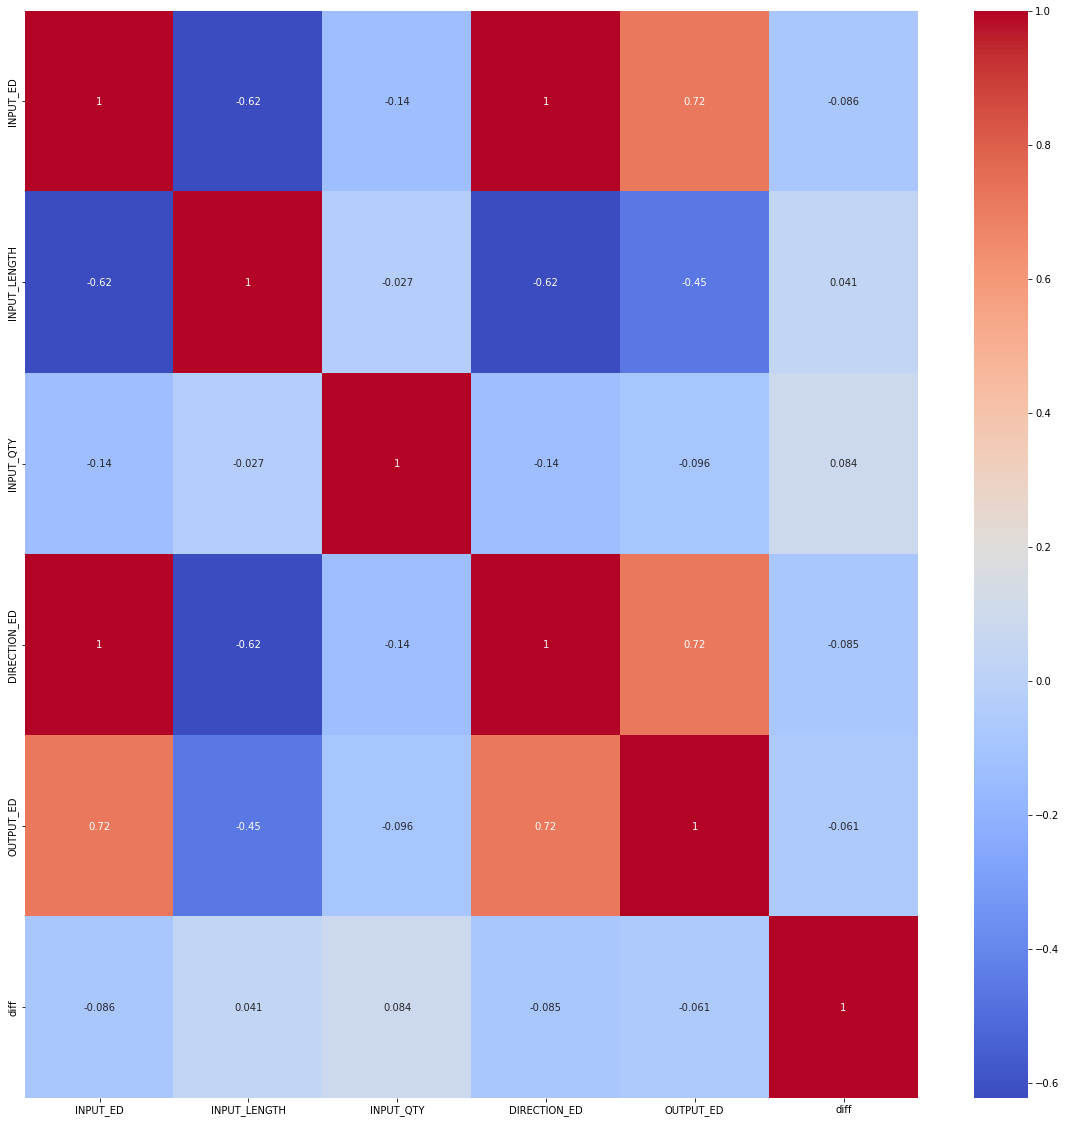

In [ ]:
#상관계수 및 상관관계 확인 (히트맵)


# **3. 데이터 변환** 

---
데이터 변환 파트는 아래 순서로 진행하며 모델에 사용할 최종 데이터셋을 생성함<br>
3-1.   컬럼 filtering<br>
3-2.   row filtering<br>
3-3.   파생변수 생성<br>
3-4.   다중공선성 제거<br>
3-5.   최종 확인<br>

---

### 3-1. 컬럼 filtering


* 날짜 및 소요시간 예측시 의미 없는 컬럼 삭제
    * WORK_START_DT 의 경우 후에 사용할 예정임으로 남겨둠
    * 삭제 : WORK_SHAPE / WORK_END_DT

In [ ]:
#불필요 컬럼 삭제 
df_tmp = df_tmp.drop(['WORK_SHAPE','WORK_END_DT'], axis=1)
df_tmp.head()

,INPUT_ED,INPUT_LENGTH,INPUT_QTY,DIRECTION_ED,OUTPUT_ED,STEEL_CATEGORY,WORK_START_DT,diff
0,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 7:00,40
1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 7:40,40
2,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 8:20,40
3,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 9:00,40
4,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 9:40,40


* 대부분 같은 값을 갖는 컬럼 삭제
    * 1개의 값을 갖는 컬럼의 경우 소요시간에 영향을 미치지 않기 때문에 삭제
    * 삭제 : FACTORY

In [ ]:
#대부분 같은 값을 갖는 컬럼 삭제 


,WORK_SHAPE,INPUT_ED,INPUT_LENGTH,INPUT_QTY,DIRECTION_ED,OUTPUT_ED,STEEL_CATEGORY,WORK_START_DT,WORK_END_DT,diff
0,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 7:00,2017-01-02 7:40,40
1,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 7:40,2017-01-02 8:20,40
2,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 8:20,2017-01-02 9:00,40
3,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 9:00,2017-01-02 9:40,40
4,1,154.00000,7450,3,148.00000,148.50000,2929,2017-01-02 9:40,2017-01-02 10:20,40


### 3-2. row filtering
* 도메인 지식(현업 의견)에 따른 이상치 삭제
    * 작업시간 120분 초과 삭제(diff)
    * 공구 절삭 깊이 0미만, 15 초과 삭제(FEED_RATE)

In [ ]:
#df_tmp에서 df_tmp['diff]가 120보다 작은 값만 남도록 분리함 


,diff
count,27129.00000
mean,45.33794
std,10.58185
min,-50.00000
25%,40.00000
50%,45.00000
75%,50.00000
max,120.00000


* 분포 확인 후 이상치 삭제(오류 데이터로 판단하여 삭제함)
    * 작업시간 0 이하 삭제(diff)
    * 투입 갯수 300 삭제(INPUT_QTY) 

In [ ]:
#df_tmp에서 df_tmp['diff]가 0보다 크고 (df_tmp['INPUT_QTY'] < 300)모다 작은 값만 남도록 분리함


,INPUT_ED,INPUT_LENGTH,INPUT_QTY,DIRECTION_ED,OUTPUT_ED,diff
count,27125.00000,27125.00000,27125.00000,27125.00000,27125.00000,27125.00000
mean,162.51468,6663.06352,3.08829,156.12598,156.62868,45.34684
std,14.27431,960.97940,0.71327,13.55163,18.64967,10.54657
min,124.00000,3200.00000,1.00000,114.00000,1.00000,10.00000
25%,154.00000,5800.00000,3.00000,148.00000,148.50000,40.00000
50%,154.00000,6700.00000,3.00000,148.00000,148.60000,45.00000
75%,175.00000,7600.00000,3.00000,168.00000,168.50000,50.00000
max,214.00000,9500.00000,9.00000,210.00000,2017.00000,120.00000


### 3-3. 파생변수 생성

* tot_length
    * 작업하게되는 총 길이가 작업소요시간에 영향을 미칠 것이라고 예상하여 황삭기를 통과하는 길이의 합을 파생변수로 생성
    * **총 길이(TOT_LENGTH) = 투입 갯수(INPUT_QTY) * 개당 길이(INPUT_LENGTH)**
    * 총 길이 변수를 생성하게되면 투입 갯수와 개당 길이 변수와 다중공선성 문제가 발생하기 때문에 변수를 만드는데 사용했던 두개의 변수를 추가로 제외시킴

In [ ]:
#tot_length 파생변수 생성 


# 다중공선성 문제로 인해 INPUT_QTY, INPUT_LENGTH 삭제



* DECREASE_ED
    * 작업시 깎아야하는 외경이 작업소요시간에 영향을 미칠 것이라고 예상하여 감소하는 외경을 파생변수로 생성
    * **감소 외경(DECREASE_ED) = 투입 외경(INPUT_ED) - 목표 외경(DIRECTION_ED)**
    * 감소 외경 변수를 생성하게되면 투입 외경과 목표 외경 변수와 다중공선성 문제가 발생하기 때문에 변수를 만드는데 사용했던 두개의 변수를 추가로 제외시킴

In [ ]:
#DECREASE_ED(감소외경) 생성 


# 다중공선성 문제로 인해 INPUT_ED, DIRECTION_ED 삭제



### 3-4. 최종 확인


* 최종적으로 소요시간 예측에 사용하는 컬럼 확인
* 결측치 여부 확인

,OUTPUT_ED,STEEL_CATEGORY,WORK_START_DT,diff,TOT_LENGTH,DECREASE_ED
0,148.50000,2929,2017-01-02 7:00,40,22350,6.00000
1,148.50000,2929,2017-01-02 7:40,40,22350,6.00000
2,148.50000,2929,2017-01-02 8:20,40,22350,6.00000
3,148.50000,2929,2017-01-02 9:00,40,22350,6.00000
4,148.50000,2929,2017-01-02 9:40,40,22350,6.00000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27125 entries, 0 to 27149
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   INPUT_LENGTH    27125 non-null  int64   
 1   INPUT_QTY       27125 non-null  int64   
 2   OUTPUT_ED       27125 non-null  float64 
 3   STEEL_CATEGORY  27125 non-null  category
 4   WORK_START_DT   27125 non-null  object  
 5   diff            27125 non-null  int64   
 6   DECREASE_ED     27125 non-null  float64 
dtypes: category(1), float64(2), int64(3), object(1)
memory usage: 1.5+ MB


# **4. 모델 준비** 

* WORK_START_DT 이용하여 year 변수생성


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


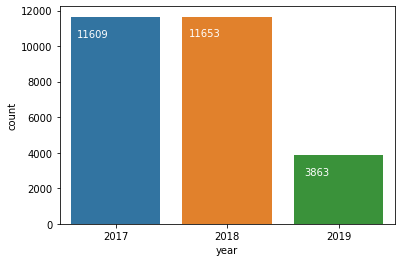

In [ ]:
#year파생 변수 생성하여 연도별 데이터 수 확인


* Training / Test 데이터 셋 분리
  * 2017, 2018년 실적을 training 데이터 셋, 2019년 실적을 test 데이터 셋으로 분리
  * 2년간 수집된 실적을 이용하여 예측모델을 만들고, 2019년 test 데이터 셋에서 예측이 잘되는지 테스트를 진행함

<figure>
<left>
<img src='https://velog.velcdn.com/images%2Fhyesoup%2Fpost%2Fca570d26-b650-4943-ad8e-5e9035b95237%2Fimage.png' />
</left>
</figure>

In [ ]:
#테스트 데이터 분할 


(23262, 3)

(23262, 1)

(3863, 3)

(3863, 1)

,DECREASE_ED,STEEL_CATEGORY,TOT_LENGTH
0,6.00000,2929,22350
1,6.00000,2929,22350
2,6.00000,2929,22350
3,6.00000,2929,22350
4,6.00000,2929,22350


# **5. 모델 생성 및 해석** 


* scikit-learn 라이브러리
    * 기계학습(Machine Learning) 에 많이 사용되는 python 라이브러리로 회귀모델, 분류모델, 클러스터링 알고리즘 등 기계학습에서 자주 사용하는 알고리즘이 구현되어 있음
    * 전처리, 평가 등 알고리즘 이외에 기계학습에서 사용되는 다양한 기법도 함께 모여있음

*  R²(결정계수)
  * 모델이 데이터를 얼마나 잘 설명하는가를 나타내는 평가지표
  * 0~1사이 값을 가지며 1에 가까울 수록 모델이 예측을 정확하게 한다고 해석 

### 5-1. 다중 선형회귀(Multiple Linear Regression)


* 회귀모델 생성

In [ ]:
#회귀모델 생성 


LinearRegression()

* 회귀모델 성능 확인
  * R²(결정계수)를 이용하여 모델 평가

In [ ]:
# train 데이터 결정계수

# test 데이터 결정계수 

0.5605697477258789

* 추정된 통계량 확인
  * 총 3개의 변수를 사용하였기 때문에 3개의 회귀계수와 1개의 절편을 추정함

In [ ]:
# 추정 된 계수 확인(상수항 제외)


# 추정 된 절편(상수항) 확인



array([[2.36071749e+00, 4.15687885e-04, 1.56645018e-03]])

array([-3.29667829])

* 예측된 y와 실제 y값 비교
  * x축 : 실제 소요시간(diff)
  * y축 : 회귀모델로 예측한 소요시간
  * 그래프에서 y=x (빨간선)에 모여있을수록 잘 예측했다고 말할 수 있음
  * 실제 소요시간이 80분 이상인 데이터에서 회귀선이 잘 예측하지 못하고 있음

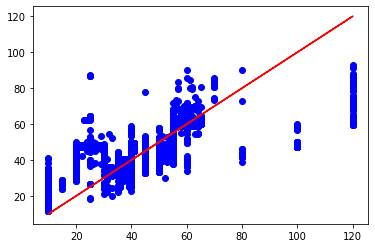

In [ ]:
#예측된 y와 실제y의 값을 비교 


### 5-2. 의사결정나무(Decision Tree)


* 의사결정나무 모델 생성
  * max_depth : 나무 모델의 최대 깊이

In [ ]:
#의사결정나무 모델 


* 의사결정나무 모델 성능 확인
  * R²(결정계수)를 이용하여 모델 평가

In [ ]:
# train 데이터 결정계수

# test 데이터 결정계수 


0.8709239424150291

* 생성된 의사결정나무 확인
  * gini 지수 : 불순도를 측정하는 지표로서, 낮을 수록 순수한 상태를 의미함

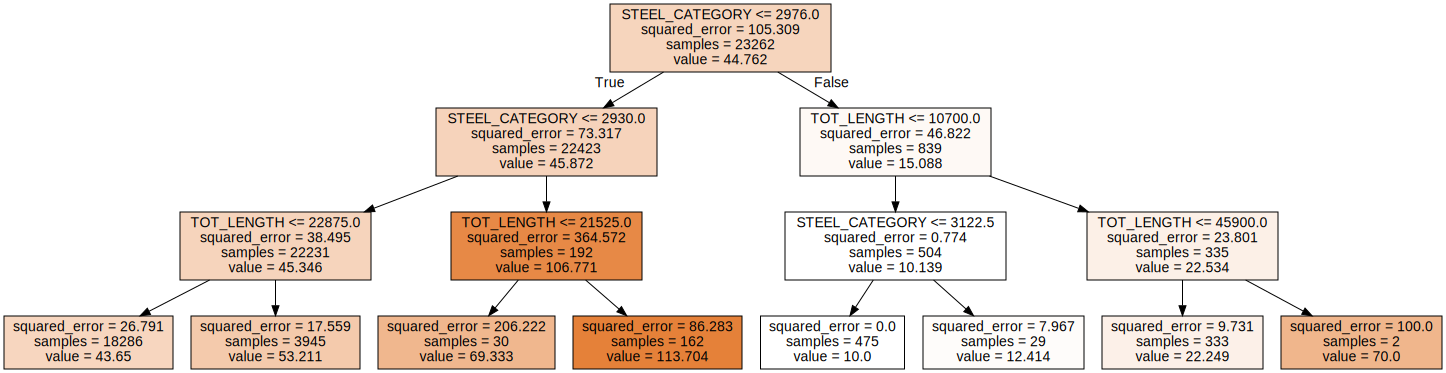

In [ ]:
#의사결정나무 트리 생성 


### 5-3. 앙상블(Ensemble) - 랜덤포레스트(Random Foreset) 모델


* 랜덤포레스트 모델 생성
  * 하이퍼파라미터 값은 임의로 할당 > 추후에 튜닝 필요
  * n_estimators : 생성할 의사결정나무의 갯수
  * max_features : 최적 분할을 위해 고려할 최대 feature 갯수
  * max_depth : 각 의사결정나무의 최대 깊이

In [ ]:
#랜덤포레스트모델 생성 


RandomForestRegressor(max_depth=3, max_features=2, n_estimators=10)

* 랜덤포레스트 모델 성능 확인
  * R²(결정계수)를 이용하여 모델 평가

In [ ]:
# train 데이터 결정계수

# test 데이터 결정계수 


0.8717915085957073

### 5-4. 3가지 모델 성능 비교


* 5-1 ~ 5-3 에서는 모델을 생성한 후 결정계수값을 생성하여 모델을 평가함
* 회귀분석에서 사용하는 여러가지 평가지표 중 가장 많이 사용되는 아래 3가지 오차관련 지표를 이용하여 추가로 성능 비교를 진행
* 모두 오차 관련 지표로 낮을 수록 좋은 모델을 의미함
  * MAE : 오차 절대값의 평균
  * MSE : 오차 제곱의 평균
  * RMSE : 오차 제곱의 평균을 구해서 제곱근을 씌운 값
<figure>
<left>
<img src='https://4.bp.blogspot.com/-wG7IbjTfE6k/XGUvqm7TCVI/AAAAAAAAAZU/vpH1kuKTIooKTcVlnm1EVRCXLVZM9cPNgCLcBGAs/s1600/formula-MAE-MSE-RMSE-RSquared.JPG' />
</left>
</figure>


In [ ]:
#메트릭 패키지 임포트

# 모델 별 예측값 저장

# MAE

print('###MAE 비교 결과### \n1.선형회귀 : {}\n2.의사결정나무 : {}\n3.랜덤포레스트 : {}\n'.format(lm_mae, tree_mae, rf_mae))              

# MSE

print('###MSE 비교 결과### \n1.선형회귀 : {}\n2.의사결정나무 : {}\n3.랜덤포레스트 : {}\n'.format(lm_mse, tree_mse, rf_mse))              


# RMSE

print('###RMSE 비교 결과### \n1.선형회귀 : {}\n2.의사결정나무 : {}\n3.랜덤포레스트 : {}'.format(lm_rmse, tree_rmse, rf_rmse))              


###MAE 비교 결과### 
1.선형회귀 : 6.261653633640643
2.의사결정나무 : 3.3016186134372814
3.랜덤포레스트 : 3.1105243180954063

###MSE 비교 결과### 
1.선형회귀 : 58.180193733283716
2.의사결정나무 : 17.089560852395476
3.랜덤포레스트 : 16.97469582385663

###RMSE 비교 결과### 
1.선형회귀 : 7.627594229721696
2.의사결정나무 : 4.133952207318739
3.랜덤포레스트 : 4.120035900797059
